# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Weight-Estimation" data-toc-modified-id="Weight-Estimation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Weight Estimation</a></div><div class="lev2 toc-item"><a href="#Algorithm" data-toc-modified-id="Algorithm-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Algorithm</a></div><div class="lev3 toc-item"><a href="#Open-Raw-Data-File-(Synthetic)" data-toc-modified-id="Open-Raw-Data-File-(Synthetic)-111"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Open Raw Data File (Synthetic)</a></div><div class="lev3 toc-item"><a href="#Data-cleaning" data-toc-modified-id="Data-cleaning-112"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Data cleaning</a></div><div class="lev3 toc-item"><a href="#Speed-estimation" data-toc-modified-id="Speed-estimation-113"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Speed estimation</a></div><div class="lev3 toc-item"><a href="#Wave-Curve-extration" data-toc-modified-id="Wave-Curve-extration-114"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>Wave Curve extration</a></div><div class="lev3 toc-item"><a href="#Load-estimation" data-toc-modified-id="Load-estimation-115"><span class="toc-item-num">1.1.5&nbsp;&nbsp;</span>Load estimation</a></div><div class="lev3 toc-item"><a href="#Weight-estimation" data-toc-modified-id="Weight-estimation-116"><span class="toc-item-num">1.1.6&nbsp;&nbsp;</span>Weight estimation</a></div>

# Weight Estimation

Weight estimation can differ respectively of the technology.

## Algorithm

In [1]:
from IPython.display import display
from matplotlib import pyplot as plt
from scipy import integrate

import numpy as np
import pandas as pd
import peakutils
import sys

# local
sys.path.insert(0, '../')

from pywim.estimation.speed import speed_by_peak
from pywim.utils import storage
from pywim.utils.dsp import wave_curve
from pywim.utils.stats import iqr

%matplotlib inline

### Open Raw Data File (Synthetic)

METADATA
sample_rate:         	2000
date_time:           	2017-32-30 01:32:11
site_id:             	001
lane_id:             	01
temperature:         	28.5
license_plate:       	AAA9999
calibration_constant:	[ 0.98  0.99  0.75]
sensors_distance:    	[0 1 2]
sensor_type:         	mixed
sensors_layout:      	|||
channel_configuration:	{"a0": "polymer", "a2": "polymer", "a1": "ceramic"}


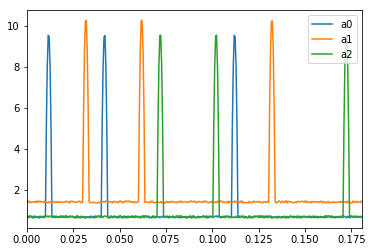

In [2]:
f = storage.open_file('../data/wim_day_001_01_20170130.h5')

dset = f[list(f.keys())[0]]
df = storage.dataset_to_dataframe(dset)

# information on the file
paddle = len(max(dset.attrs, key=lambda v: len(v)))

print('METADATA')
print('='*80)
for k in dset.attrs:
    print('{}:'.format(k).ljust(paddle, ' '), dset.attrs[k], sep='\t')

df.plot()
plt.show()

### Data cleaning

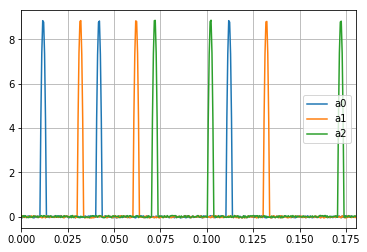

In [3]:
data_cleaned = df.copy()

for k in data_cleaned.keys():
    # use the first 10 points as reference to correct the baseline
    # in this case should work well
    data_cleaned[k] -= data_cleaned[k].values[:10].mean()

data_cleaned.plot()
plt.grid(True)
plt.show()

### Speed estimation

In [4]:
# calculates the speed for each pair of sensors by axles
speed = speed_by_peak.sensors_estimation(
    data_cleaned, dset.attrs['sensors_distance']
)

display(speed)

[array([ 48.6453618 ,  51.13999574,  48.6453618 ]),
 array([ 48.6453618 ,  51.13999574,  48.6453618 ]),
 array([ 49.86149584,  49.24592182,  49.86149584])]

### Wave Curve extration

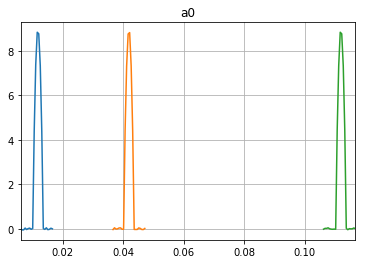

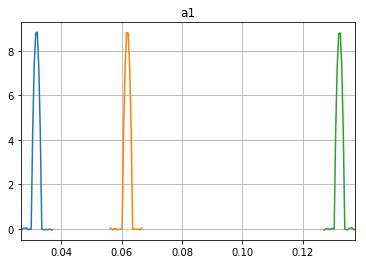

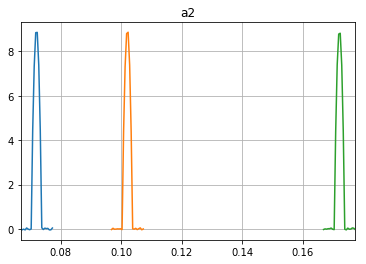

In [5]:
curves = []

for k in data_cleaned.keys():
    curves.append(
        wave_curve.select_curve_by_threshold(
            data_cleaned[k], threshold=1, delta_x=5
        )
    )
    
    for c in curves[-1]: 
        # plot each axle measured
        c.plot()
        
    plt.grid(True)
    plt.title(k)
    plt.show()

### Load estimation

In [6]:
load = []

t = 1/dset.attrs['sample_rate']

for axles_curve in curves:
    # composite trapezoidal rule
    load.append([
        integrate.trapz(v, dx=t)
        for v in axles_curve
    ])
    
print('Load estimation:')
display(load)

Load estimation:


[[0.020523844740033416, 0.020519563695956859, 0.020611970227450021],
 [0.020416608987557091, 0.020464392425316912, 0.020457100807274801],
 [0.020641151851042965, 0.020571896825825085, 0.020618040876383439]]

### Weight estimation

In [7]:
# W = (v/L) * A * C
v = speed
a = load
l = 0.5  # sensor width
c = dset.attrs['calibration_constant']
w = []

for i, _load in enumerate(load):
    # sensor data
    _w = []
    for j in range(len(_load)):
        # axle data
        _w.append((v[i][j]/l) * a[i][j] * c[i])
    w.append(_w)
    
weight = np.matrix(w)

print('Axle estimated weight by each sensor:')
display(weight)

weight_axles = []

for i in range(weight.shape[0]):
    v = pd.Series(weight[:, i].view(np.ndarray).flatten())
    weight_axles.append(iqr.reject_outliers(v).mean())
    
print('Axle estimated weight:')
display(weight_axles)

gvw = sum(weight_axles)

print('Gross Vehicle Weigh:', gvw)

Axle estimated weight by each sensor:


matrix([[ 1.95684411,  2.05676598,  1.96524643],
        [ 1.9664832 ,  2.0721669 ,  1.97038328],
        [ 1.54379806,  1.51962303,  1.54206954]])

Axle estimated weight:


[1.8223751226021012, 1.8828519740541274, 1.8258997488004169]

Gross Vehicle Weigh: 5.53112684546
